In [1]:
!pip install pennylane

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 24.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 930.0/930.0 kB 30.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 28.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 35.5 MB/s eta 0:00:00


Epoch 0: Cost = 2.9257480502404083
Epoch 10: Cost = 1.7077741241300433
Epoch 20: Cost = 0.9379794537765243
Epoch 30: Cost = 0.863180388291643
Epoch 40: Cost = 0.7792223689773526


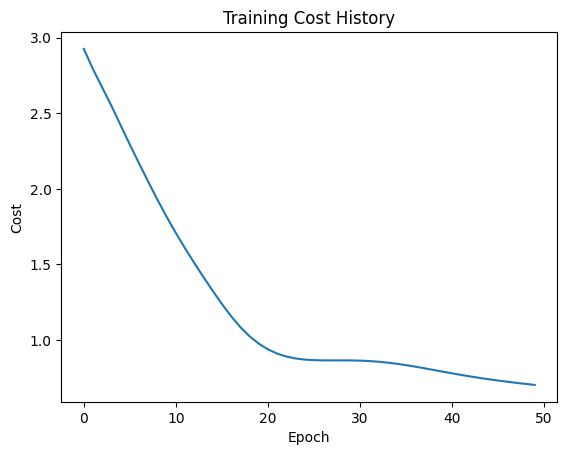

Test Accuracy: 0.8


In [2]:
import pennylane as qml
from pennylane import numpy as np
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# Load Iris dataset
iris = datasets.load_iris()
X = iris.data
y = iris.target

# Standardize and reduce to 2 features with PCA
scaler = StandardScaler()
X = scaler.fit_transform(X)
pca = PCA(n_components=2)
X = pca.fit_transform(X)

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Quantum device with 2 qubits
n_qubits = 2
dev = qml.device("default.qubit", wires=n_qubits)

# Quantum Circuit
def circuit(params, x):
    # Data encoding
    qml.RX(x[0], wires=0)
    qml.RY(x[1], wires=1)

    # First layer of trainable rotations
    qml.Rot(params[0], params[1], params[2], wires=0)
    qml.Rot(params[3], params[4], params[5], wires=1)
    qml.CNOT(wires=[0, 1])

    # Second layer of trainable rotations
    qml.Rot(params[6], params[7], params[8], wires=0)
    qml.Rot(params[9], params[10], params[11], wires=1)
    qml.CNOT(wires=[1, 0])

# Define QNode
@qml.qnode(dev)
def qnode(params, x):
    circuit(params, x)
    return qml.probs(wires=[0, 1])  # Measure probabilities of all basis states

# Variational classifier
def variational_classifier(params, x):
    probabilities = qnode(params, x)
    return np.argmax(probabilities)  # Return the class with the highest probability

# Cost function for training
def cost(params, X, Y):
    total_loss = 0
    for x, y in zip(X, Y):
        probs = qnode(params, x)
        target = np.zeros(len(probs))
        target[y] = 1  # One-hot encoding of the label
        loss = -np.sum(target * np.log(probs + 1e-6))  # Cross-entropy loss
        total_loss += loss
    return total_loss / len(Y)

# Initialize parameters
np.random.seed(42)
params = np.random.uniform(0, 0.1, 12)

# Training loop
opt = qml.AdamOptimizer(stepsize=0.05)
num_epochs = 50
cost_history = []

for epoch in range(num_epochs):
    params, _cost = opt.step_and_cost(lambda p: cost(p, X_train, y_train), params)
    cost_history.append(_cost)
    if epoch % 10 == 0:
        print(f"Epoch {epoch}: Cost = {_cost}")

# Plot cost history
plt.plot(cost_history)
plt.xlabel("Epoch")
plt.ylabel("Cost")
plt.title("Training Cost History")
plt.show()

# Evaluate model
y_pred = [variational_classifier(params, x) for x in X_test]
accuracy = accuracy_score(y_test, y_pred)
print("Test Accuracy:", accuracy)


Graphical Quantum Circuit Visualization:


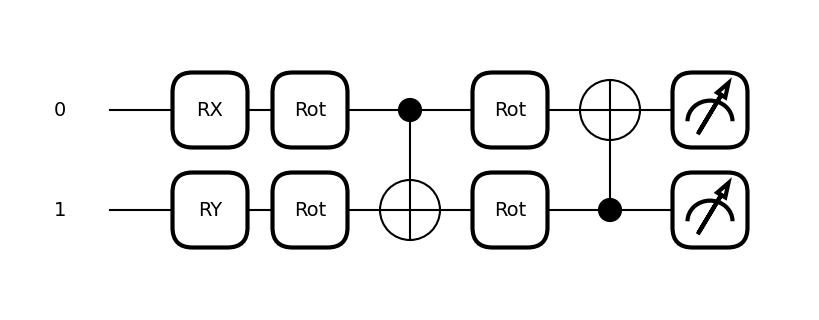

In [4]:
print("Graphical Quantum Circuit Visualization:")
sample_input = X_test[0]
fig, ax = qml.draw_mpl(qnode)(params, sample_input)
plt.show()
